# Estimating Historic CLV

Step 1: Understand the dataset  


In [7]:
# Loading the dataset from csv file
import pandas as pd
missing_values = ['na','--']
df = pd.read_csv('./clv_transactions.csv', na_values= missing_values)
df.head()
#Observations: Date and TransactionID are ordinal attributes. Amount is a continuous numerical attribute. Customer ID is nominal.

TransactionID TransactionDate  CustomerID  Amount
0              1        9/4/2012           1   20.26
1              2       5/15/2012           2   10.87
2              3       5/23/2014           2    2.21
3              4      10/24/2014           2   10.48
4              5      10/13/2012           2    3.94

In [8]:
#1 Checking for missing values
df.isnull().values.any()

False

In [10]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
min_date = df['TransactionDate'].min()
max_date = df['TransactionDate'].max()
print('Range of dates in the dataset is from {} to {}'.format(min_date, max_date))

Range of dates in the dataset is from 2010-01-04 00:00:00 to 2015-12-31 00:00:00


Range of dates in the dataset is from 2010-01-04 to 2015-12-31 

In [5]:
len(df['CustomerID'].unique())

1000

There are 1000 unique customers in the dataset

In [6]:
print(df['Amount'].describe())
var_amount = df['Amount'].var()
print('variance in Amount:',var_amount)

count    4186.000000
mean        9.028082
std        38.723909
min        -1.000000
25%         3.310000
50%         6.885000
75%        11.690000
max      2033.000000
Name: Amount, dtype: float64
variance in Amount: 1499.5411107517461


For the Amount field:  
min = -1 units, max = 2033 units, variance = 1499 units and standard deviation = 38.723 units  
The transaction amount has to be a positive number, but we find that in the dataset, amount has negative values. This outlier will be treated in the next step.

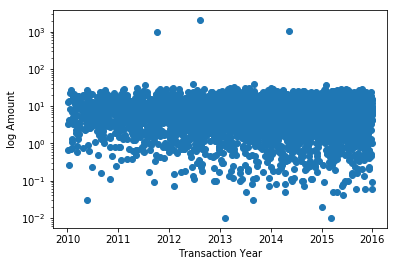

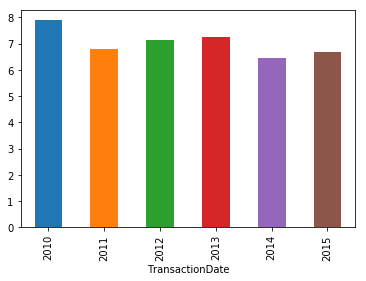

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
dates = [pd.to_datetime(i) for i in df['TransactionDate']]
plt.plot_date(dates, df['Amount']) #Scatter plot of log(amount) vs transaction date
plt.yscale('log')
plt.xlabel('Transaction Year')
plt.ylabel('log Amount')
plt.show()

#Bar Plot of median amount vs transaction date
df["TransactionDate"] = df["TransactionDate"].astype("datetime64")
df['Amount'].groupby(df["TransactionDate"].dt.year).median().plot('bar')



As shown in the two plots above, transaction amounts in general do not increase over time.

Step 2: Explore the dataset  



Data outside upper and lower bound:
       TransactionID TransactionDate  CustomerID   Amount
23               24      2011-10-07           7  1003.00
54               55      2015-01-29          13    37.27
62               63      2012-01-21          14    28.72
136             137      2014-02-15          34    25.60
165             166      2014-01-20          41    29.12
211             212      2014-05-14          54  1027.00
263             264      2012-06-21          69    38.29
330             331      2012-08-14          84    24.27
374             375      2013-05-02          94    29.50
418             419      2013-12-31         100    30.31
496             497      2013-04-22         119    25.59
585             586      2013-03-16         145    30.43
613             614      2010-05-23         155    26.67
650             651      2013-03-25         168    27.26
955             956      2013-06-05         238    24.56
966             967      2015-12-24         241    

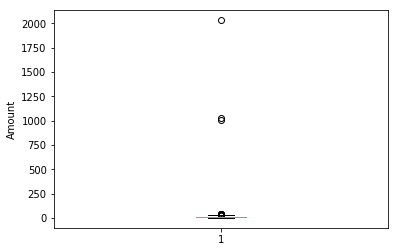

In [8]:
#For Amount
def outlier_test():
    q1 = df['Amount'].quantile(0.25)
    q2 = df['Amount'].median()
    q3 = df['Amount'].quantile(0.75)
    IQR = q3 - q1
    upper_bound = q3 + 1.5 * IQR
    lower_bound = q1 - 1.5 * IQR
    print('Data outside upper and lower bound:\n',df[(df['Amount'] > upper_bound) | (df['Amount'] < lower_bound)])
    print('Any negative/zero values : \n', df[(df['Amount']<=0)])
    plt.boxplot(df['Amount'])
    plt.ylabel('Amount')
    plt.show()

outlier_test()

For the outlier analysis, I make use of box plot since they are robust to outliers.  The box plot clearly shows outliers in the form of abnormally high values near the 1000 mark and 2000 mark. 
Also, we observe that there are 2 records in the data where the Amount column has a negative value. I treat this as abnormal values too.

First off, I drop the negative/zero values from the data frame. 

In [9]:
#Removing the negative values from amount 
df = df.drop(df.index[df['Amount']<=0])


Next, based on the box plot, I remove the outlier values which are greater than 250. Once this is done, I shall reconstruct the box plot and histogram to check the transformed data set.

In [10]:
#Removing abnormally high values
df = df.drop(df.index[df['Amount'] > 250])

Data outside upper and lower bound:
       TransactionID TransactionDate  CustomerID  Amount
54               55      2015-01-29          13   37.27
62               63      2012-01-21          14   28.72
136             137      2014-02-15          34   25.60
165             166      2014-01-20          41   29.12
263             264      2012-06-21          69   38.29
330             331      2012-08-14          84   24.27
374             375      2013-05-02          94   29.50
418             419      2013-12-31         100   30.31
496             497      2013-04-22         119   25.59
585             586      2013-03-16         145   30.43
613             614      2010-05-23         155   26.67
650             651      2013-03-25         168   27.26
955             956      2013-06-05         238   24.56
966             967      2015-12-24         241   24.47
1076           1077      2013-11-07         277   24.47
1080           1081      2015-01-26         278   28.82
1122       

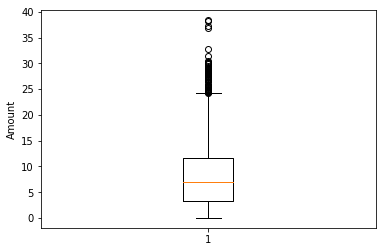

In [11]:
outlier_test()

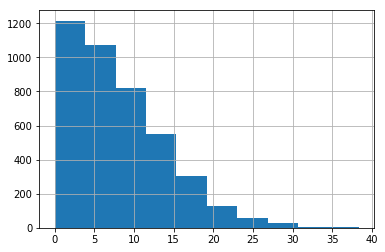

In [12]:
df['Amount'].hist()

Step 3: Determine origin year of customers  
Some of the underlying customers are brand new and others have been customers for almost five years. Obviously the newer   customers will have (generally) spent less on average than the old ones. So, we need to separate the customers into groups   based on how long ago they were acquired (e.g. customers acquired in 2010, vs customers acquired in 2011, ...).   


In [13]:
#Creating a new column 'OriginYear' in df
df['OriginYear'] = df['TransactionDate'] #Initializing column
df['OriginYear'] = df.groupby('CustomerID')['OriginYear'].transform('min')   #Computing the value of earliest txn date for each customer ID

In [14]:
df['OriginYear'] = pd.to_datetime(df['OriginYear']) 

In [15]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

In [16]:
df['OriginYear'] = df['OriginYear'].dt.year #Extracting year from date and assigning it

Step 4: Calculate cumulative transaction amounts  


In [17]:
df_cumulative_txn_amt = pd.DataFrame(columns = ['OriginYear', '12', '24', '36', '48', '60', '72'])

In [18]:
#populating origin year column based on unique values obtained in the original dataframe
df_cumulative_txn_amt['OriginYear'] = sorted(df['OriginYear'].unique())

In [19]:
df_cumulative_txn_amt

OriginYear   12   24   36   48   60   72
0        2010  NaN  NaN  NaN  NaN  NaN  NaN
1        2011  NaN  NaN  NaN  NaN  NaN  NaN
2        2012  NaN  NaN  NaN  NaN  NaN  NaN
3        2013  NaN  NaN  NaN  NaN  NaN  NaN
4        2014  NaN  NaN  NaN  NaN  NaN  NaN
5        2015  NaN  NaN  NaN  NaN  NaN  NaN

In [20]:
for row_index, row in df_cumulative_txn_amt.iterrows():
        col_idx = 0
        df2 = df[df['OriginYear'] == row[0]]
        for col in range(len(row) - row_index):
            if col_idx != 0:
                age_in_months = int(df_cumulative_txn_amt.columns[col_idx])
                age_in_years  = int(age_in_months/12)
                txn_year_upper_bound = row[0] + age_in_years
                df_cumulative_txn_amt.at[row_index, df_cumulative_txn_amt.columns[col_idx]] = df2[df2['TransactionDate'].dt.year < txn_year_upper_bound]['Amount'].sum()
            col_idx += 1       

In [21]:
#Printing table to standard output
df_cumulative_txn_amt

OriginYear       12       24       36       48       60       72
0        2010  2259.67  3614.78  5274.81  6632.37  7930.69  8964.49
1        2011  2238.46   3757.9  5465.99  6703.11  7862.24      NaN
2        2012  2181.35  3874.69  5226.86  6501.85      NaN      NaN
3        2013  2179.85  3609.81  5227.75      NaN      NaN      NaN
4        2014  1830.85  3262.05      NaN      NaN      NaN      NaN
5        2015  1912.17      NaN      NaN      NaN      NaN      NaN

Step 5: Calculate cumulative transaction amounts  


In [22]:
df_new_customers = pd.DataFrame(columns = ['OriginYear', '12', '24', '36', '48', '60', '72'])

In [23]:
#populating origin year column based on unique values obtained in the original dataframe
df_new_customers['OriginYear'] = sorted(df['OriginYear'].unique())

In [24]:
df_new_customers

OriginYear   12   24   36   48   60   72
0        2010  NaN  NaN  NaN  NaN  NaN  NaN
1        2011  NaN  NaN  NaN  NaN  NaN  NaN
2        2012  NaN  NaN  NaN  NaN  NaN  NaN
3        2013  NaN  NaN  NaN  NaN  NaN  NaN
4        2014  NaN  NaN  NaN  NaN  NaN  NaN
5        2015  NaN  NaN  NaN  NaN  NaN  NaN

In [25]:
colsize = df_new_customers.columns.size
for idx, i in enumerate(df.groupby('OriginYear')):
    df_new_customers.loc[idx, 1:colsize-idx] = i[1]['CustomerID'].unique().size 

In [26]:
# Printing New customer table to standard output
df_new_customers

OriginYear   12   24   36   48   60   72
0        2010  172  172  172  172  172  172
1        2011  170  170  170  170  170  NaN
2        2012  163  163  163  163  NaN  NaN
3        2013  180  180  180  NaN  NaN  NaN
4        2014  155  155  NaN  NaN  NaN  NaN
5        2015  160  NaN  NaN  NaN  NaN  NaN

Step 6: Historic CLV  


In [27]:
df_historic_clv = pd.DataFrame(columns = ['OriginYear', '12', '24', '36', '48', '60', '72'])
df_historic_clv['OriginYear'] = sorted(df['OriginYear'].unique())

In [28]:
import numpy as np
for column in df_historic_clv.columns[1:]:
    df_historic_clv[column] = df_cumulative_txn_amt[column]/df_new_customers[column]  #dividing amount.cltv triangle by NewCustomers.cltv triangle
    df_historic_clv[column] = np.around(df_historic_clv[column].astype('float'), 2) # rounding to 2 decimal places

In [29]:
#Printing Historic CLV table to standard output
df_historic_clv

OriginYear     12     24     36     48     60     72
0        2010  13.14  21.02  30.67  38.56  46.11  52.12
1        2011  13.17  22.11  32.15  39.43  46.25    NaN
2        2012  13.38  23.77  32.07  39.89    NaN    NaN
3        2013  12.11  20.05  29.04    NaN    NaN    NaN
4        2014  11.81  21.05    NaN    NaN    NaN    NaN
5        2015  11.95    NaN    NaN    NaN    NaN    NaN

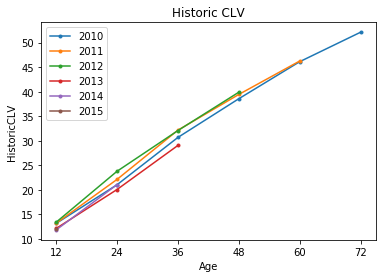

In [30]:
for i in df_historic_clv.iterrows():
    plt.plot(i[1][1:], marker = '.')
plt.legend(['2010','2011','2012','2013','2014','2015'])
plt.xlabel('Age')
plt.ylabel('HistoricCLV')
plt.title('Historic CLV')
plt.show()

At this point, weâ€™d like to combine all of our data to create a single curve of Historic CLV.   
A simple, but effective approach   to doing this is to take a volume-weighted average of the Historic CLV for each group at each Age, weighted by the number of   customers in each group

In [31]:
#pd.DataFrame(df_new_customers.values*df_cumulative_txn_amt.values, columns=df.columns[1:], index=df.index)
df3 = df_new_customers[df_new_customers.columns[1:]].multiply(df_historic_clv[df_historic_clv.columns[1:]])

In [32]:
df4 = pd.DataFrame(columns = [ '12', '24', '36', '48', '60', '72'])

In [33]:
for idx, column in enumerate(df3):
    df4.loc[0, df4.columns[idx]] = df3.iloc[:,idx].sum()/df_new_customers.iloc[:, idx+1].sum()
    #print(df3.iloc[:,idx].sum()/df_new_customers.iloc[:, idx+1].sum())

In [34]:
# Printing volume weighted single historic CLV
df4

12       24       36       48       60     72
0  12.6023  21.5719  30.9421  39.2822  46.1796  52.12

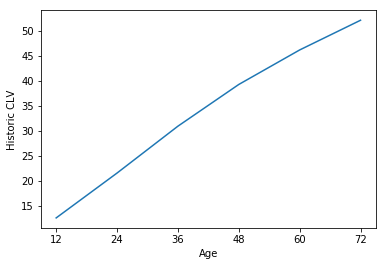

In [35]:
#Plotting a single historic CLV line
row = df4.iloc[0]
plt.plot(row)
plt.xlabel('Age')
plt.ylabel('Historic CLV')
plt.show()

Step 7: Interpreting your results  



A customer acquired in 2011 has spent $46.25 to date (i.e., the end of 2015).

Based on the Historic CLV vs Age plot below for different customer origin years, it can be observed that each group of customers exhibit similar patters of spending. Since each group of customers exhibit similar spending patters, we can make a reasonable assertion that a decent lower bound for CLV is $52.12. 

In this case, CLV refers to the revenue/business attributable to a customer over a 5-year relationship with the business.       

  Implication: Here the CLV can help the business evalute the worth of investing in a long-term relationship with a customer.
The business can use this metric to make marketing and sales decisions to know how much (at max) to spend to acquire a single customer. Ideally, the CLV should be greater than the cost of acquiring a customer. Hence, on average, the business should spend no more than $52.12 to acquire a single customer.



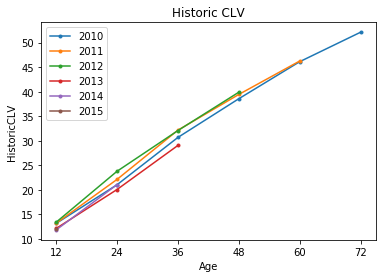

In [36]:
for i in df_historic_clv.iterrows():
    plt.plot(i[1][1:], marker = '.')
plt.legend(['2010','2011','2012','2013','2014','2015'])
plt.xlabel('Age')
plt.ylabel('HistoricCLV')
plt.title('Historic CLV')
plt.show()